# Úkol č. 1 - předzpracování dat a binární klasifikace

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

In [1]:
# # Install necessary libraries

# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install numpy
# !pip install scipy

In [2]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as treelib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

print('Import success!')

Import success!


In [3]:
# Load data from the file data.csv
df = pd.read_csv("data.csv")

print("Read success!")

Read success!


### Data exploration

In [4]:
# Display the first 5 rows of the DataFrame df
df.head()

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


In [5]:
# Provide summary statistics for each column
df.describe(include='all')

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
count,1000.000000,1000.00000,1000.000000,1000,1000,802.000000,1000.000000,1000.00000,1000,999.000000,233,998,566
unique,NaN,NaN,NaN,999,2,NaN,NaN,NaN,746,NaN,157,3,313
top,NaN,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,B57 B59 B63 B66,S,"New York, NY"
freq,NaN,NaN,NaN,2,628,NaN,NaN,NaN,9,NaN,5,698,46
mean,499.500000,0.39800,2.288000,NaN,NaN,29.850686,0.496000,0.40200,NaN,34.264352,NaN,NaN,NaN
std,288.819436,0.48973,0.840096,NaN,NaN,14.328743,1.024223,0.91719,NaN,53.315077,NaN,NaN,NaN
min,0.000000,0.00000,1.000000,NaN,NaN,0.166700,0.000000,0.00000,NaN,0.000000,NaN,NaN,NaN
25%,249.750000,0.00000,1.750000,NaN,NaN,21.000000,0.000000,0.00000,NaN,7.925000,NaN,NaN,NaN
50%,499.500000,0.00000,3.000000,NaN,NaN,28.000000,0.000000,0.00000,NaN,14.458300,NaN,NaN,NaN
75%,749.250000,1.00000,3.000000,NaN,NaN,39.000000,1.000000,0.00000,NaN,31.275000,NaN,NaN,NaN


In [6]:
# Display the data types of each column
df.dtypes

ID             int64
survived       int64
pclass         int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

In [7]:
# Display concise information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


#### Comments:
* `sex` feature values must be replaced with bollean(numeric) values
* `ID`, `name`, `ticket`, `home.dest`, `cabin` features have no effect on human survival (should be removed from dataset)
  * ID - each value is unique
  * name - each value is unique
  * ticket - 75% of data is unique values
  * home.dest - 45% of data is NaN, 30% of data is unique values
  * cabin - 75% of data is NaN 
*  `age`, `fare` features have NaN values, so we could just remove all rows with nan values or replaced as -1, but i will try to replace with average values
*  `embarked` feature sould be processed using `.get_dummies()` function

### Feature engineering

In [8]:
# Drop unnecessary columns
df.drop(columns=['ID', 'name', 'ticket', 'home.dest', 'cabin'], inplace=True)

In [9]:
# View what data is in the column 'sex'
df.sex.unique()

array(['male', 'female'], dtype=object)

In [10]:
# Change column 'sex' to boolean
df['sex'] = df['sex'].astype('category')
df['sex'].replace(['female', 'male'], [0,1], inplace=True)
df['sex'] = df['sex'].astype(int)

In [11]:
# Encode 'embarked'
df['embarked'] = df['embarked'].astype('category')
df = pd.get_dummies(data=df, columns=['embarked']) # for classification tree is not realy necessery, can be used .cat.codes

From now we must split the data into 3 sets:
* `train`ing set = set for training model
* `val`idation set = set for select best hyperparameters
* `test`ing set = set for final model estimating/evaluating 

In [12]:
# Undependent
x_ = df.drop(columns=['survived'])
# Dependent
y_ = df['survived']

In [13]:
# Split the data 
Xtrain, Xtest, ytrain, ytest = train_test_split(x_, y_, test_size=0.2, random_state=33) # test set = 20% of all data
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=33) # 80% of all data = 30% (validation set) + 70% (training set)

In [14]:
# Replace NaN with mean for 'age' and 'fare' features
def nan_handler(data):
    data['age'].replace(np.nan, data['age'].mean(), inplace=True)
    data['fare'].replace(np.nan, data['fare'].mean(), inplace=True)
    

In [15]:
nan_handler(Xtrain)
nan_handler(Xval)
nan_handler(Xtest)

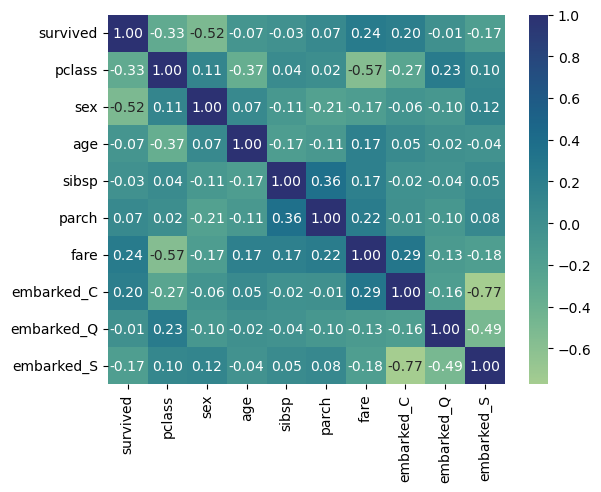

In [16]:
# Fill NaN values correlation matrix
nan_handler(df)
# Visualize the correlation matrix
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap="crest")
plt.show()

In [17]:
# Correlation for 'survived'
df.corr()['survived']

survived      1.000000
pclass       -0.325112
sex          -0.515430
age          -0.068003
sibsp        -0.028753
parch         0.069093
fare          0.235020
embarked_C    0.199437
embarked_Q   -0.012611
embarked_S   -0.172665
Name: survived, dtype: float64

#### Comments:
* `age`, `sibsp`,`embarked_Q` and `parch` have small influence comparing to others

## DecisionTreeClassifier

In [18]:
# Hyperparametrs combinations
param_grid = {
    'max_depth': range(1,51), 
    'criterion': ['entropy', 'gini', 'log_loss']
}
param_comb = ParameterGrid(param_grid)

In [19]:
# Lists for collecting accuracy scores from trees
val_acc = []
train_acc = []

# Collect accuracy scores
for params in param_comb:
    tree = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion']) # set hyperparametrs for DecisionTree
    tree.fit(Xtrain, ytrain) # train DecisionTree
    train_acc.append(metrics.accuracy_score(ytrain, tree.predict(Xtrain))) # store results
    val_acc.append(metrics.accuracy_score(yval, tree.predict(Xval))) # store results

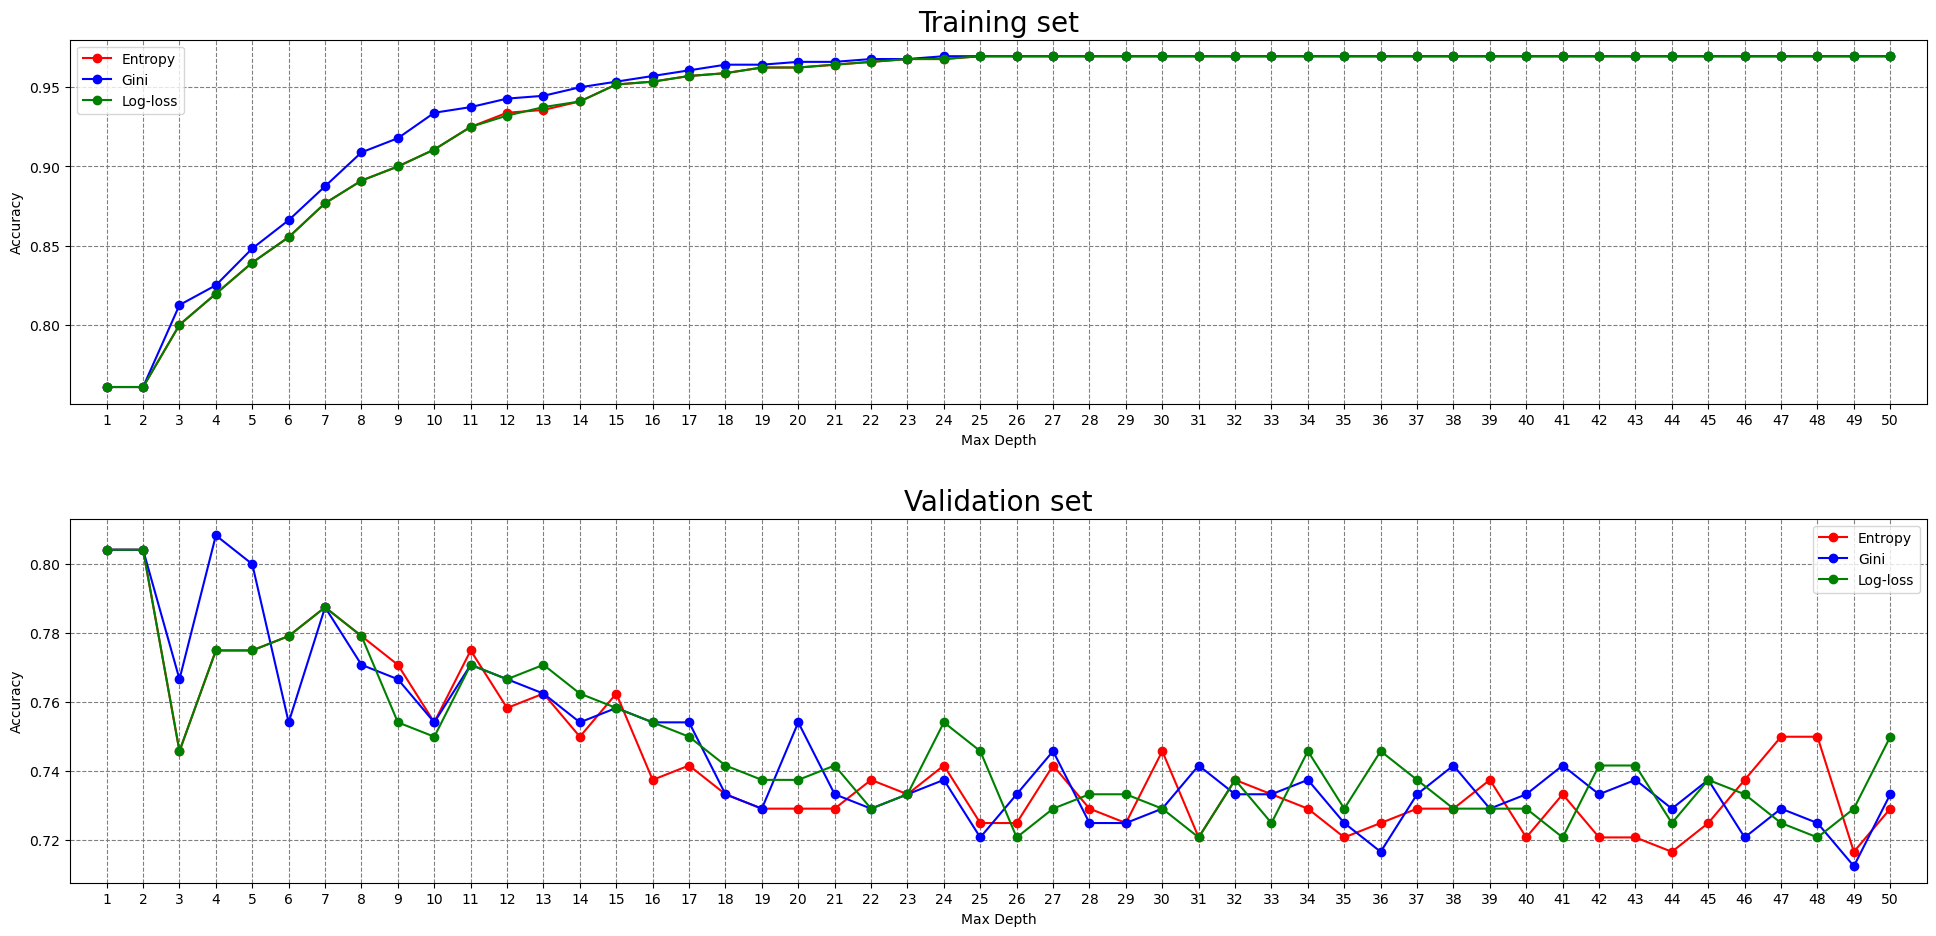

In [20]:
# Plot
fig = plt.figure(figsize=(20,10)) # set size

# Training set
ax1 = fig.add_subplot(2,1,1)
ax1.plot(train_acc[:50], 'or-', label='Entropy') # lineplot
ax1.plot(train_acc[50:100], 'ob-', label='Gini') # lineplot
ax1.plot(train_acc[100:], 'og-', label='Log-loss') # lineplot
ax1.set_xlim(-1,50)
ax1.set_xticks(range(0,50,1))
ax1.set_xticklabels(range(1,51,1))
ax1.legend()
ax1.grid(color='grey',linestyle='--')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training set', fontdict={'fontsize':20})

# Validation set
ax2 = fig.add_subplot(2,1,2)
ax2.plot(val_acc[:50], 'or-', label='Entropy') # lineplot
ax2.plot(val_acc[50:100], 'ob-', label='Gini') # lineplot
ax2.plot(val_acc[100:], 'og-', label='Log-loss') # lineplot
ax2.set_xlim(-1,50)
ax2.set_xticks(range(0,50,1))
ax2.set_xticklabels(range(1,51,1))
ax2.legend()
ax2.grid(color='grey',linestyle='--')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation set', fontdict={'fontsize':20})

fig.tight_layout(pad=3.0)
plt.show()

From above graphs:
* we understand that at some point increasing the maximum tree depth means decreasing the accuracy (overfitting)
  * (first) graph for training set shows us how good model predict data on which it trained 
  * (second) graph for validation set shows us how good model predict data which it has not yet encountered

In [21]:
# Hyperparameter search
best_params = param_comb[np.argmax(val_acc)]
print(best_params) # best params found

{'max_depth': 4, 'criterion': 'gini'}


In [22]:
# Training DecisionTree for last time
tree = DecisionTreeClassifier(**best_params) # set hyperparameters for DecisionTree
tree.fit(Xtrain,ytrain) # training
# print('Train set accuracy score :      {0:.6f}'.format(metrics.accuracy_score(ytrain, tree.predict(Xtrain))))
print('Validation set accuracy score : {0:.6f}'.format(metrics.accuracy_score(yval,   tree.predict(Xval))))
# print('Test set accuracy score : {0:.6f}'.format(metrics.accuracy_score(ytest,  tree.predict(Xtest))))
# print('Train set F1 score :      {0:.6f}'.format(metrics.f1_score(ytrain, tree.predict(Xtrain))))
print('Validation set F1 score : {0:.6f}'.format(metrics.f1_score(yval,   tree.predict(Xval))))
# print('Test set F1 score :       {0:.6f}'.format(metrics.f1_score(ytest,  tree.predict(Xtest))))


Validation set accuracy score : 0.808333
Validation set F1 score : 0.705128


#### Comments:
* relative to the F1 score, our model does not look impressive, but accuracy score looks fine

[F1 score](https://en.wikipedia.org/wiki/F-score) is another type of estimating model, better use in situation like this (classification).<br>
Some times model can predict well if person survive, but predict poorly if person not survive. For estimating does model predict both classes (survive and not survive) well we use F1 score.
<br>
[Youtube example](https://www.youtube.com/watch?v=jJ7ff7Gcq34)

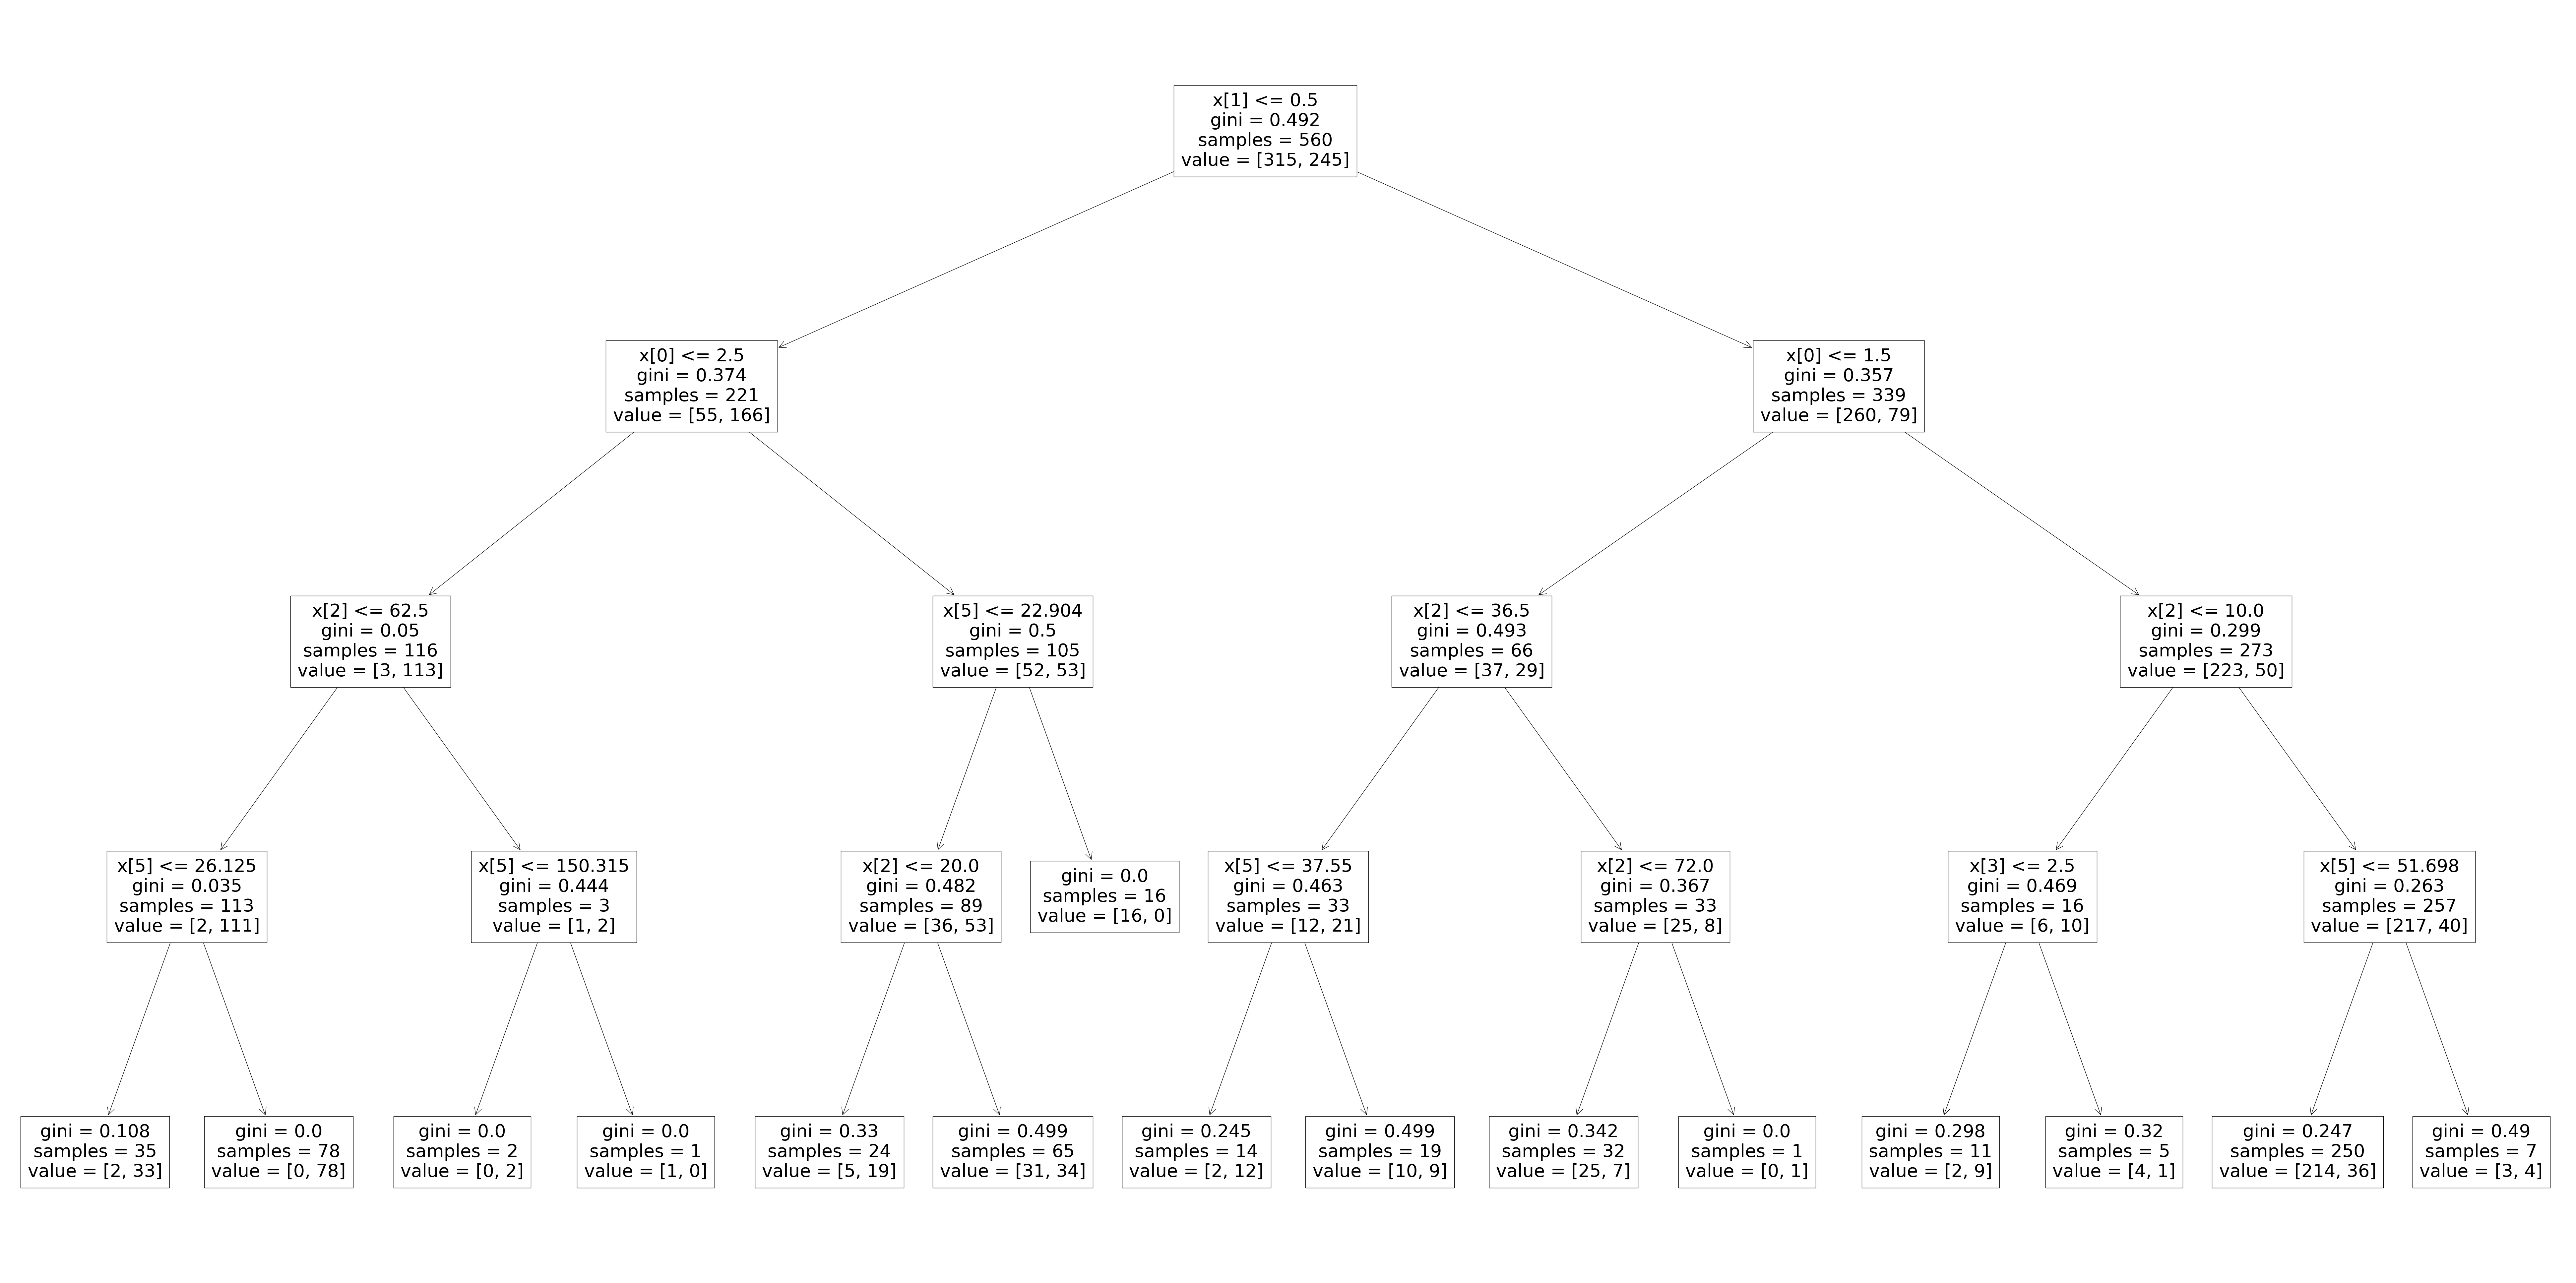

In [23]:
# Plot the decision tree
plt.figure(figsize=(100,50))
treelib.plot_tree(tree)
plt.show()

__predict_proba__  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X)


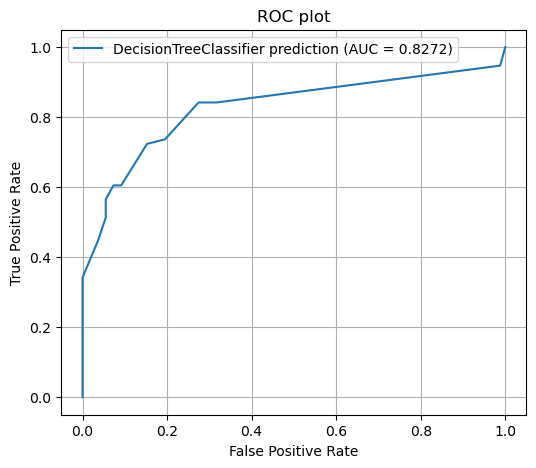

In [24]:
# ROC calculations 
tree_probs = tree.predict_proba(Xval) # prediction probabilities
tree_probs = tree_probs[:,1] # probabilities with positive outcome (positive means survive)
tree_fpr, tree_tpr, tree_threshold = metrics.roc_curve(yval, tree_probs)

# AUC calculations
tree_auc = metrics.roc_auc_score(yval, tree_probs) # auroc score
# print('DecisionTreeClassifier AUC = {0:.6f}'.format(tree_auc)) # auc found!

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(tree_fpr,tree_tpr, label='DecisionTreeClassifier prediction (AUC = {0:.4f})'.format(tree_auc))

plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

#### Comments:
* Using this graph we can choose which treshold value should we use
* We should always choose value at which False Positive Rate is as low as posible and True Positive Rate is high
* By AUC value we can compare diffrent madels (Higher AUC = Better model)
<br>

Links:
* [step by step on whiteboard](https://www.youtube.com/watch?v=A_ZKMsZ3f3o)
* [example with logistic regression](https://www.youtube.com/watch?v=4jRBRDbJemM&t)
* [wiki](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

## K-nearest neighbors (KNN)

PS: We will use same data as we used for DecisionTree

In [25]:
# Scale data
mm_scaler = MinMaxScaler()
mm_Xtrain = mm_scaler.fit_transform(Xtrain)
mm_Xval = mm_scaler.transform(Xval)
mm_Xtest = mm_scaler.transform(Xtest)

st_scaler = StandardScaler()
st_Xtrain = st_scaler.fit_transform(Xtrain)
st_Xval = st_scaler.transform(Xval)
st_Xtest = st_scaler.transform(Xtest)

KNN algorithm is sensitive.
<br> 
Some features might have values close to inf and at the same time other features have values close to zero or negative close to -inf. Because of it some algorithms like KNN may misunderstand the data or not find correlation between them or give great devotion to one thing and completely ignore another, so we use scalers, so all features values have same range and nothing will be ignored.
<br>
* MinMaxScaler - rescales the data set such that all feature values are in the range [0, 1]
* StandardScaler - removes the mean and scales the data to unit variance

In [26]:
# Hyperparametrs combinations
param_grid = {
    'n_neighbors': range(1,51), 
    'weights':['uniform', 'distance'],
    'metric':['euclidean','manhattan'],
    'p':[1,2]
}
param_comb = ParameterGrid(param_grid)

In [27]:
# Lists for collecting results
mm_val_acc = [] # List to store F1 scores for MinMaxScaler
st_val_acc = [] # List to store F1 scores for StandardScaler

# Collect results for different parameter combinations
for params in param_comb:
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'], weights=params['weights'], p=params['p'])
    # MinMaxScaler
    knn.fit(mm_Xtrain, ytrain) # training
    mm_val_acc.append(metrics.f1_score(yval, knn.predict(mm_Xval))) # store results
    # StandardScaler
    knn.fit(st_Xtrain, ytrain) # training
    st_val_acc.append(metrics.f1_score(yval, knn.predict(st_Xval))) # store results


In [28]:
# Hyperparameter search

# MinMaxScaler
mm_best_params = param_comb[np.argmax(mm_val_acc)]
print("using MinMaxScaler:")
print(mm_best_params, " F1 score = ", max(mm_val_acc)) # best params found

#StandardScaler
st_best_params = param_comb[np.argmax(st_val_acc)]
print("using StandardScaler:")
print(st_best_params, "  F1 score = ", max(st_val_acc)) # best params found

best_params = st_best_params if max(st_val_acc) > max(mm_val_acc) else mm_best_params

using MinMaxScaler:
{'weights': 'uniform', 'p': 1, 'n_neighbors': 21, 'metric': 'manhattan'}  F1 score =  0.7074829931972789
using StandardScaler:
{'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'metric': 'manhattan'}   F1 score =  0.7172413793103448


#### Comments:
* StandardScaler wins! Flawless Victory 🥷

In [29]:
# KNN classifier with the previously determined best parameters (best_params) 
knn = KNeighborsClassifier(**best_params)
knn.fit(st_Xtrain, ytrain)

print('Validation set F1 score :       {0:.6f}'.format(metrics.f1_score(yval,  knn.predict(st_Xval))))

Validation set F1 score :       0.717241


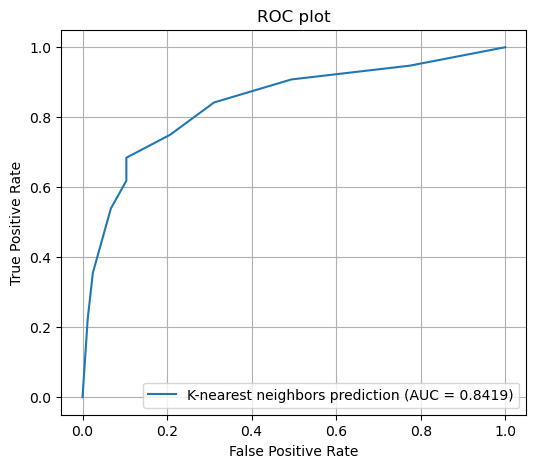

In [30]:
# ROC calculations 
knn_probs = knn.predict_proba(st_Xval) # prediction probabilities
knn_probs = knn_probs[:,1] # probabilities with positive outcome
knn_fpr, knn_tpr, knn_threshold = metrics.roc_curve(yval, knn_probs)

# AUC calculations
knn_auc = metrics.roc_auc_score(yval, knn_probs) # auroc score
# print('DecisionTreeClassifier AUC = {0:.6f}'.format(tree_auc)) # auc found!

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(knn_fpr,knn_tpr, label='K-nearest neighbors prediction (AUC = {0:.4f})'.format(knn_auc))

plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

### Comparing KNN and DecisionTree

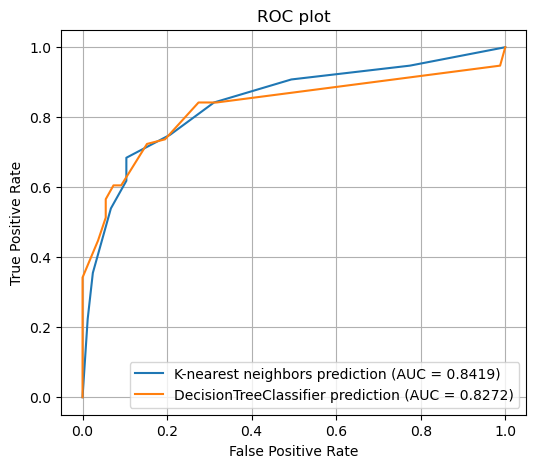

KNN  Validation set F1 score :       0.717241
TREE Validation set F1 score :       0.705128


In [31]:
plt.figure(figsize=(6,5))
plt.plot(knn_fpr,knn_tpr, label='K-nearest neighbors prediction (AUC = {0:.4f})'.format(knn_auc))
plt.plot(tree_fpr, tree_tpr, label='DecisionTreeClassifier prediction (AUC = {0:.4f})'.format(tree_auc))
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

print('KNN  Validation set F1 score :       {0:.6f}'.format(metrics.f1_score(yval,  knn.predict(st_Xval))))
print('TREE Validation set F1 score :       {0:.6f}'.format(metrics.f1_score(yval,  tree.predict(Xval))))

#### Comments:
* almost same thing, 1% diffrent
* KNN gave better results, i will use that model for final task

### What accuracy can we expect from our model on unknown data


In [32]:
print('Test set F1 score :       {0:.6f}'.format(metrics.f1_score(ytest,  knn.predict(st_Xtest))))

Test set F1 score :       0.693642


### Final task: get predictions

In [33]:
# Read file
eval = pd.read_csv('evaluation.csv')

First of all, basic data pre-processing (same steps as before)

In [34]:
# Drop features
ids = eval['ID'] # need this for later
eval.drop(columns=['ID', 'name', 'ticket', 'home.dest', 'cabin'], inplace=True)

# Encode 'sex'
eval['sex'] = eval['sex'].astype('category')
eval['sex'].replace(['female','male'], [0,1], inplace=True)
eval['sex'] = eval['sex'].astype(int)

# Encode 'embarked'
eval['embarked'] = eval['embarked'].astype('category')
eval = pd.get_dummies(data=eval, columns=['embarked'])

# Replace NaN
eval['age'].replace(np.nan, df['age'].mean(), inplace=True)
eval['fare'].replace(np.nan, df['fare'].mean(), inplace=True)

eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      309 non-null    int64  
 1   sex         309 non-null    int64  
 2   age         309 non-null    float64
 3   sibsp       309 non-null    int64  
 4   parch       309 non-null    int64  
 5   fare        309 non-null    float64
 6   embarked_C  309 non-null    bool   
 7   embarked_Q  309 non-null    bool   
 8   embarked_S  309 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 15.5 KB


In [35]:
# Apply scaler
eval = st_scaler.transform(eval)

In [36]:
# Get predictions
predictions = knn.predict(eval)
# Convert predictions from np.ndarray to pd.Series
predictions = pd.Series(predictions) 

In [37]:
results = pd.concat([ids, predictions], axis=1) # create dataframe 
results.rename(columns={0:'survived'}, inplace=True) # rename column
results

,ID,survived
0,1000,0
1,1001,1
2,1002,1
3,1003,0
4,1004,1
...,...,...
304,1304,0
305,1305,0
306,1306,0
307,1307,1


In [38]:
# Saving the received prediction to a file
results.to_csv('results.csv', index=False)

During the execution of the assignment, the following steps were undertaken:
* Data Loading: 
  * Data was loaded from the data.csv file and split into training, validation, and test sets for subsequent use.
* Data Preprocessing: 
  * An overview and transformation of features were performed for use in the chosen classification models.
  * Some features were dropped, they were not relevant for modeling.
  * Missing values in the data were handled.
* Modeling:
  * Decision tree and k-nearest neighbors models were employed for classification.
  * Analysis and evaluation of each model were conducted, including the tuning of main hyperparameters.
* Model Evaluation:
  * F1 scores were calculated for models with the best hyperparameter values.
  * ROC curves were plotted, and the area under the curve (AUC) was computed.
* Selection of the Final Model:
  * Based on the evaluation results, the final model with the best characteristics was chosen.
* Prediction on New Data:
  * Data from the evaluation.csv file was loaded.
  * Using the selected final model, predictions were made on the new data.
  * Prediction results were saved in the results.csv file.

The execution involved data preprocessing methods, visualization, model training, hyperparameter tuning, and model evaluation. 